# Summer analysis 2023: ndvi+ndmi+marginalization res 10

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: (CSV) Average ndvi and ndmi min, median, mean, max data by marginalization group.

Analysis 2: (MAP, BOXPLOT) Zones that may recieve irrigation within urban spaces and its relation with marginalization. Places without vegetation are discarted.(ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds).

Analysis 3: (CSV) From analisis 2, ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min) are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
city = 'Tuxtla'

In [3]:
#Save csvs to output>figures>ndmi_ndmi_marg_bycity?
csv_dataset = True 
#"averagerasterdata_bymarg": csv containing ndvi and ndmi min, mean, median and max, along with the marginalization category
#"ndmi_diffextremes_marg": csv containing the top 10% and bottom 10% ndmi_diff (humidity variation/conservation) related to the marginalization degree.

#Save figures to output>figures>ndmi_ndmi_marg_bycity?
save_plots = True

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(14798, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,Tuxtla
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,Tuxtla


Data download - NDMI

In [5]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(14798, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a6d23105607fff,"POLYGON ((-93.02585 16.74721, -93.02522 16.747...",10,0.009967,0.126183,0.009086,0.192869,-0.169196,0.362065,0.001571,Tuxtla
1,8a6d23105777fff,"POLYGON ((-93.02336 16.74949, -93.02273 16.749...",10,-0.033892,0.103949,-0.031758,0.127919,-0.173783,0.301703,0.001004,Tuxtla


Data download - Municipalities (in order to download marginalization)

In [6]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(5, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,07012,07,012,Berriozábal,"POLYGON ((-93.35648 17.02684, -93.35152 17.026...",Tuxtla
1,07027,07,027,Chiapa de Corzo,"POLYGON ((-92.97831 16.90241, -92.97714 16.901...",Tuxtla


Data download - Marginalization

In [7]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['07012', '07027', '07079', '07086', '07101']

In [8]:
# donwload hexagons with marg data
hex_marg = gpd.GeoDataFrame()
marg_table = 'hex_bins_marg_2020'
marg_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(301, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-93.24941 16.80069, -93.24952 16.805...",886d23cec3fffff,07012,956.51074,33.509167,94.452040,89.186570,0.143904,0.723079,14.713311,6.656461,48.313313,162.691730,26.788376,106.117220,114.738561,0.896295
1,"POLYGON ((-93.28545 16.81872, -93.28534 16.813...",886d23ce17fffff,07012,434.51410,12.143864,30.479908,17.612888,0.576161,0.708615,1.000822,5.931827,15.050458,40.246998,5.926347,31.430008,109.960848,0.858973


## Data treatment

### Data treatment - Bring marginalization data (res8) to ndvi (res10)

Find ndvi centroids in order to intersect res10 info with a single res8 hex

In [9]:
#Find centroids
ndvi_res10_calc = ndvi_res10.to_crs("EPSG:6372")
centroids = ndvi_res10_calc.centroid
centroids = centroids.to_crs("EPSG:4326")

#Turn into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

#Review result
print(centroids_gdf.shape)
centroids_gdf.head(2)

(14798, 1)


,geometry
0,POINT (-93.02657 16.75110)
1,POINT (-93.02709 16.74572)


Intersect centroids with orginal ndvi data to keep hex_id data

In [10]:
centroids_hexid = gpd.overlay(centroids_gdf,ndvi_res10,keep_geom_type=True)

columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

#Review result
print(centroids_hexid.shape)
centroids_hexid.head(2)

(14798, 2)


,hex_id,geometry
0,8a6d23105717fff,POINT (-93.02657 16.75110)
1,8a6d231056f7fff,POINT (-93.02709 16.74572)


Intersect centroids with marginalization data

In [11]:
centroids_marg = gpd.overlay(centroids_hexid,hex_marg,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020']
centroids_marg = centroids_marg[columns_tokeep]

#Review result
print(centroids_marg.shape)
centroids_marg.head(2)

(14639, 4)


,hex_id,pobtot,im_2020,imn_2020
0,8a6d23105717fff,1088.6708,111.084146,0.867748
1,8a6d231056f7fff,1088.6708,111.084146,0.867748


Merge centroids_marg back with res10 geometry

In [12]:
ndvi_marg = pd.merge(ndvi_res10,centroids_marg, on='hex_id')

#Review result
print(ndvi_marg.shape)
ndvi_marg.head(2)

(14639, 14)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,pobtot,im_2020,imn_2020
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,Tuxtla,1088.6708,111.084146,0.867748
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,Tuxtla,1088.6708,111.084146,0.867748


### Data treatment - Merge NDVI_MARG with NDMI

In [13]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_marg = ndvi_marg.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(14639, 21)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,pobtot,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,...,1088.6708,111.084146,0.867748,-0.018352,0.123086,-0.027127,0.162648,-0.179113,0.341761,0.001485
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,...,1088.6708,111.084146,0.867748,0.055813,0.174836,0.085401,0.293145,-0.180671,0.473815,0.001675


### Data treatment - Create data categories

Data treatment - Creating vegetation categories

In [14]:
# Creating vegetation categories
ndvi_ndmi_marg['ndvi_median_rango'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.4 )&
             (ndvi_ndmi_marg.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.2)&
             (ndvi_ndmi_marg.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.1)&
             (ndvi_ndmi_marg.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_ndmi_marg['ndvi_median_rango'] = pd.Categorical(ndvi_ndmi_marg['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(14639, 22)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,...,111.084146,0.867748,-0.018352,0.123086,-0.027127,0.162648,-0.179113,0.341761,0.001485,Mínima densidad vegetal
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,...,111.084146,0.867748,0.055813,0.174836,0.085401,0.293145,-0.180671,0.473815,0.001675,Moderada densidad vegetal


Reviewing ndvi proportions

In [15]:
ndviproportions = ndvi_ndmi_marg.groupby('ndvi_median_rango').count()

columns_tokeep = ['hex_id']
ndviproportions = ndviproportions[columns_tokeep]

ndviproportions = ndviproportions.rename(columns={'hex_id':'count'})
ndviproportions['%'] = ndviproportions['count'].apply(lambda x: (x/(ndviproportions['count'].sum()))*100)

ndviproportions

,count,%
ndvi_median_rango,,
Suelo artificial/Agua/Piedra,425,2.903204
Suelo,2697,18.423390
Mínima densidad vegetal,7786,53.186693
Moderada densidad vegetal,3678,25.124667
Alta densidad vegetal,53,0.362047


Data treatment - Creating marginalization categories

In [16]:
ndvi_ndmi_marg['Grado_Marg'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.946436 )&
             (ndvi_ndmi_marg.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.926536)&
             (ndvi_ndmi_marg.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.8999)&
             (ndvi_ndmi_marg.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
ndvi_ndmi_marg['Grado_Marg'] = pd.Categorical(ndvi_ndmi_marg['Grado_Marg'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(14639, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,...,0.867748,-0.018352,0.123086,-0.027127,0.162648,-0.179113,0.341761,0.001485,Mínima densidad vegetal,Muy Alto
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,...,0.867748,0.055813,0.174836,0.085401,0.293145,-0.180671,0.473815,0.001675,Moderada densidad vegetal,Muy Alto


Reviewing marg proportions

In [17]:
margproportions = ndvi_ndmi_marg.groupby('Grado_Marg').count()

columns_tokeep = ['hex_id']
margproportions = margproportions[columns_tokeep]

margproportions = margproportions.rename(columns={'hex_id':'count'})
margproportions['%'] = margproportions['count'].apply(lambda x: (x/(margproportions['count'].sum()))*100)

margproportions

,count,%
Grado_Marg,,
Muy Alto,2853,19.489036
Alto,4233,28.915910
Medio,5017,34.271467
Bajo,2487,16.988865
Muy bajo,49,0.334722


## Analysis 1 - Average min, mean, median, max data by marginalization group

In [18]:
# Group by calculating min, mean, median and max ndvi and ndmi for each marginalization group
marginalization_behaviour = ndvi_ndmi_marg.groupby('Grado_Marg').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_median':np.mean,'ndvi_max':np.mean,
                                                                      'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_median':np.mean,'ndmi_max':np.mean})

# Calculate the summary statistics across columns
summary_df = pd.DataFrame({
    'ndvi_min': pd.Series(ndvi_ndmi_marg['ndvi_min'].mean(), index=['Todos los hex']),
    'ndvi_mean': pd.Series(ndvi_ndmi_marg['ndvi_mean'].mean(), index=['Todos los hex']),
    'ndvi_median': pd.Series(ndvi_ndmi_marg['ndvi_median'].mean(), index=['Todos los hex']),
    'ndvi_max': pd.Series(ndvi_ndmi_marg['ndvi_max'].mean(), index=['Todos los hex']),
    'ndmi_min': pd.Series(ndvi_ndmi_marg['ndmi_min'].mean(), index=['Todos los hex']),
    'ndmi_mean': pd.Series(ndvi_ndmi_marg['ndmi_mean'].mean(), index=['Todos los hex']),
    'ndmi_median': pd.Series(ndvi_ndmi_marg['ndmi_median'].mean(), index=['Todos los hex']),
    'ndmi_max': pd.Series(ndvi_ndmi_marg['ndmi_max'].mean(), index=['Todos los hex'])
})

# Append the summary row to the original dataframe
marginalization_behaviour_with_summary = pd.concat([marginalization_behaviour, summary_df])

# Rename columns to clarify that they represent the mean values of each category
marginalization_behaviour_with_summary.rename(columns={
    'ndvi_min': 'avg ndvi_min',
    'ndvi_mean': 'avg ndvi_mean',
    'ndvi_median': 'avg ndvi_median',
    'ndvi_max': 'avg ndvi_max',
    'ndmi_min': 'avg ndmi_min',
    'ndmi_mean': 'avg ndmi_mean',
    'ndmi_median': 'avg ndmi_median',
    'ndmi_max': 'avg ndmi_max'},inplace=True)

marginalization_behaviour_with_summary

,avg ndvi_min,avg ndvi_mean,avg ndvi_median,avg ndvi_max,avg ndmi_min,avg ndmi_mean,avg ndmi_median,avg ndmi_max
Muy Alto,0.087903,0.363639,0.359177,0.600209,-0.167266,0.014035,0.023800,0.192148
Alto,0.100009,0.321872,0.321106,0.507621,-0.133697,0.012702,0.017014,0.165449
Medio,0.063229,0.300442,0.310333,0.481078,-0.110199,0.026378,0.029541,0.166346
Bajo,0.067608,0.244954,0.247821,0.379869,-0.103467,0.009518,0.009110,0.132421
Muy bajo,0.048678,0.378253,0.372623,0.687349,-0.180730,0.050896,0.059946,0.243719
Todos los hex,0.079368,0.309789,0.312556,0.495467,-0.127208,0.017236,0.021430,0.165611


In [19]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = marginalization_behaviour_with_summary.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/averagerasterdata_bymarg_{}.csv".format(city.lower(),city.lower()))

(6, 8)


## Analysis 2 - Zones that may recieve irrigation within urban spaces (ndmi_diff analysis) and its relation with marginalization

### Anlysis 2 Data treatment - Filter for places with vegetation

NDVI filtering for places with vegetation

In [20]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(data_withveg.shape)
data_withveg.head(2)

(11517, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a6d23105717fff,"POLYGON ((-93.02655 16.75039, -93.02592 16.750...",10,0.374349,0.134391,0.358555,0.588545,0.182909,0.405636,0.000264,...,0.867748,-0.018352,0.123086,-0.027127,0.162648,-0.179113,0.341761,0.001485,Mínima densidad vegetal,Muy Alto
1,8a6d231056f7fff,"POLYGON ((-93.02707 16.74500, -93.02645 16.745...",10,0.489630,0.186555,0.463545,0.796878,0.243133,0.553745,-0.000549,...,0.867748,0.055813,0.174836,0.085401,0.293145,-0.180671,0.473815,0.001675,Moderada densidad vegetal,Muy Alto


Visual correlation analyisis

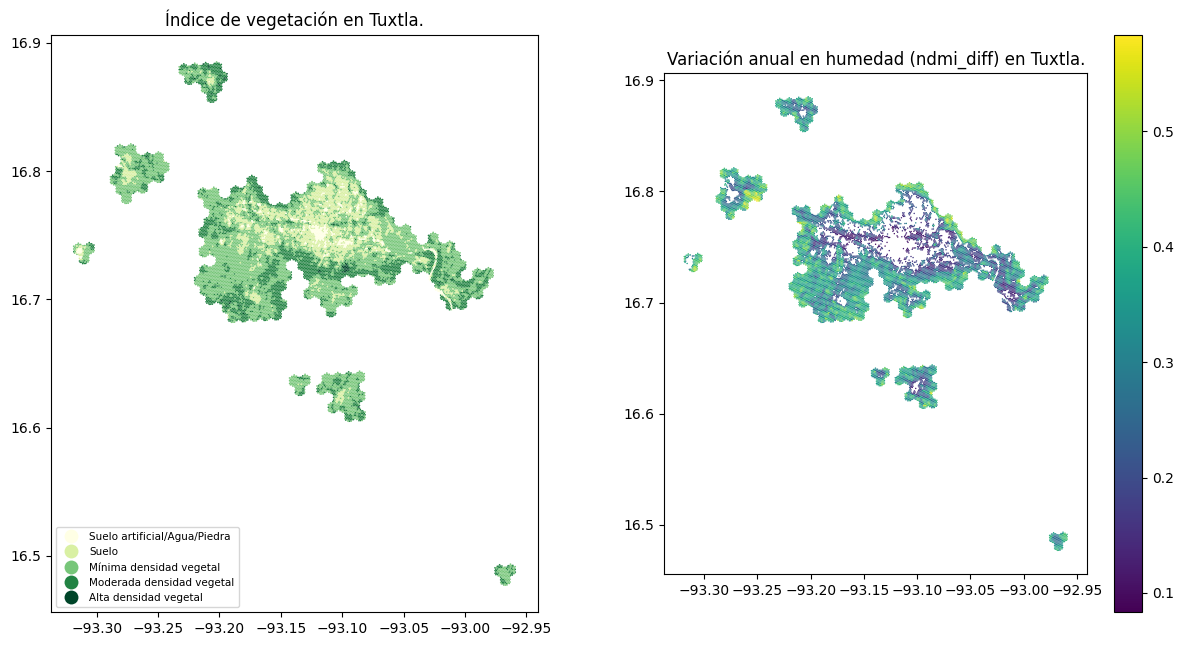

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))

#---------- Ax 0 ----------
ax[0].set_title('Índice de vegetación en {}.'.format(city))
ndvi_ndmi_marg.plot('ndvi_median_rango', 'YlGn', ax=ax[0],legend=True,
                    legend_kwds={'fontsize':7.5,'loc':'lower left'})

#---------- Ax 1 ----------
ax[1].set_title('Variación anual en humedad (ndmi_diff) en {}.'.format(city))
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[1], legend=True)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_{}.svg".format(city.lower(),city.lower()))

### Analysis 2 Data analysis - Boxplot

In [22]:
boxplot_gdf = ndvi_ndmi_marg.copy()
boxplot_gdf = boxplot_gdf.sort_values('Grado_Marg')
boxplot_gdf.loc[boxplot_gdf.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg


      index  Grado_Marg
2  Muy Alto        2853
1      Alto        4233
0     Medio        5017
3      Bajo        2487
4  Muy bajo          49


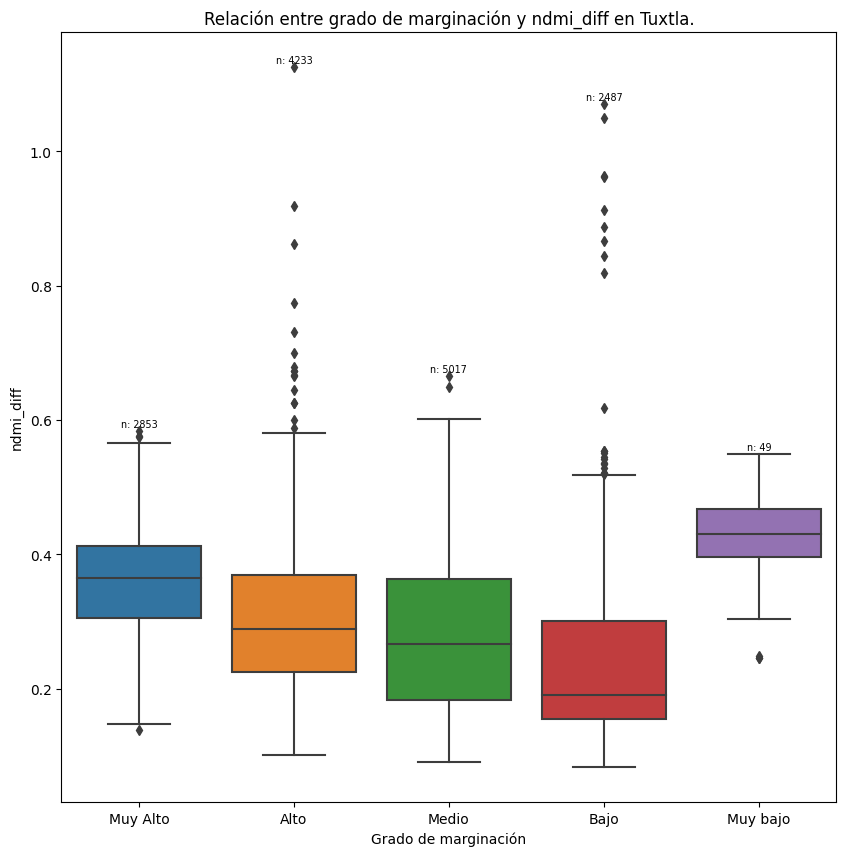

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

#---------Plot
sns.boxplot(x=np.array(boxplot_gdf.Grado_Marg) , 
            y=np.array(boxplot_gdf.ndmi_diff), 
            ax=ax)

#---------Format
plt.title('Relación entre grado de marginación y ndmi_diff en {}.'.format(city))
plt.xlabel('Grado de marginación')
plt.ylabel('ndmi_diff')

# ------------------------------------------- Add number of hex per marginalization group -------------------------------------------

#---------Position
#Calculate max of each Marginalization group to position number of observations above each boxplot
maxs = boxplot_gdf.groupby(['Grado_Marg'])['ndmi_diff'].max()
num_maxs = maxs.values
#Drop NaNs
num_maxs = num_maxs[~np.isnan(num_maxs)]

#---------Count
#Calculate number of observations per group
obs = boxplot_gdf['Grado_Marg'].value_counts()
obs = obs.reset_index()
obs = obs.sort_values('index')
print(obs)
#Drop Ceros by turning them to nans
obs = obs['Grado_Marg'].apply(lambda x: np.nan if x==0 else x)
obs = obs[~np.isnan(obs)]

num_obs = obs.values
num_obs = [str(x) for x in num_obs.tolist()]
num_obs = ["n: " + i for i in num_obs]

#---------Add it to the plot
pos = range(len(num_obs))
for tick,label in zip(pos,ax.get_xticklabels()):
    #ax.text(x,y,text)
    ax.text(pos[tick],
            num_maxs[tick] + 0.005,
            num_obs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')
# ------------------------------------------- ------------------------------------------- -------------------------------------------

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_marg_boxplot_{}.svg".format(city.lower(),city.lower()))

## Analysis 3 - ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min)

### Analysis 3 Data treatment - Find mins and maxs ndmi_diff

Find 10% mins and 10% maxs

In [24]:
# Finding len of 10% of data
tenpercent = int(len(data_withveg)/10)

#Finding smallest and largest ndmi_diff
ndmi_diff_mins = data_withveg.nsmallest(tenpercent,'ndmi_diff')
ndmi_diff_maxs = data_withveg.nlargest(tenpercent,'ndmi_diff')

Create maxs and mins category

In [25]:
ndmi_diff_mins['ndmi_diff_cat'] = '10%_mins'
ndmi_diff_maxs['ndmi_diff_cat'] = '10%_maxs'

ndmi_diff_extremes = pd.concat([ndmi_diff_mins, ndmi_diff_maxs])

print(ndmi_diff_extremes.shape)
ndmi_diff_extremes.head(2)

(2302, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg,ndmi_diff_cat
6985,8a6d231a5867fff,"POLYGON ((-93.13842 16.75498, -93.13779 16.755...",10,0.229751,0.084411,0.239075,0.320032,0.054777,0.265255,-0.000857,...,0.027032,0.033492,0.021628,0.074634,-0.008537,0.083171,-0.000213,Mínima densidad vegetal,Bajo,10%_mins
7305,8a6d23116997fff,"POLYGON ((-93.12342 16.76652, -93.12279 16.766...",10,0.259573,0.082211,0.279833,0.344538,0.073035,0.271503,-0.000899,...,0.047270,0.036916,0.044724,0.096803,0.005232,0.091571,0.000143,Mínima densidad vegetal,Medio,10%_mins


Plot data to get a visual

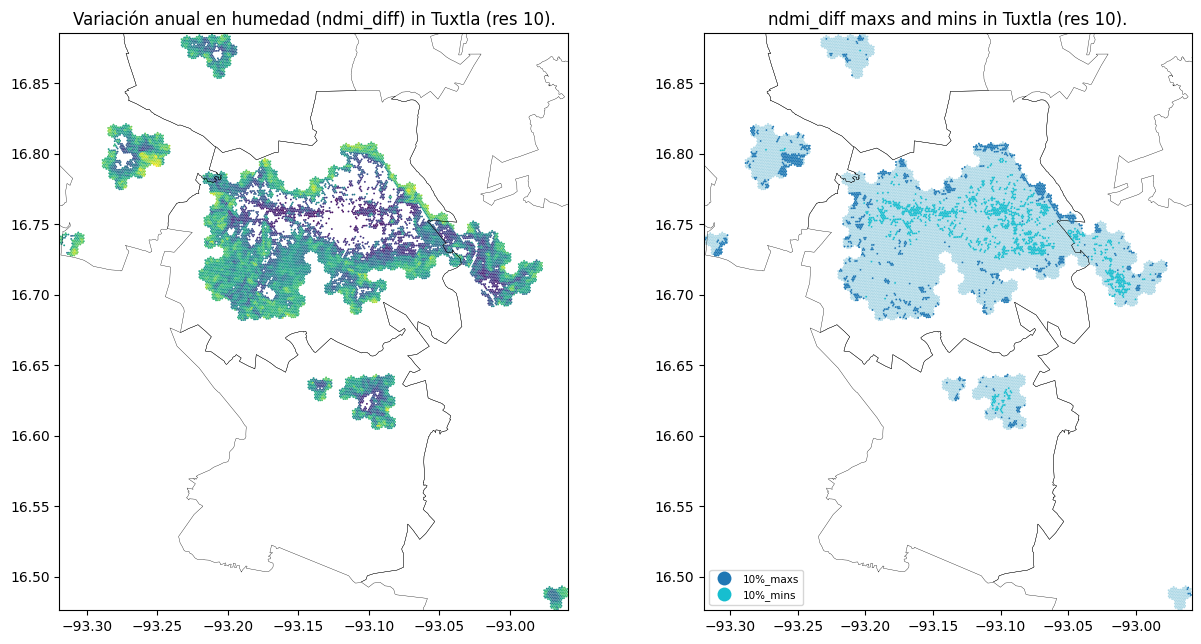

In [26]:
#Create figure
fig,ax = plt.subplots(1,2,figsize=(15,7.5))

#--------- First ax ---------
#Plotting ndmi_diff
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[0], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[0], zorder = 1)

##---------Format
ax[0].set_title('Variación anual en humedad (ndmi_diff) in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[0].set_xlim(data_withveg.total_bounds[0], data_withveg.total_bounds[2])
ax[0].set_ylim(data_withveg.total_bounds[1], data_withveg.total_bounds[3])


#--------- Second ax ---------
#Plot base hexes
ndvi_ndmi_marg.plot(color = 'lightblue',ax=ax[1], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[1], zorder = 1)
#Plot extremes data
ndmi_diff_extremes.plot('ndmi_diff_cat',ax=ax[1],zorder = 2, 
                        legend=True, legend_kwds={'fontsize':7.5,'loc':'lower left'})

##---------Format
ax[1].set_title('ndmi_diff maxs and mins in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[1].set_xlim(ndvi_ndmi_marg.total_bounds[0], ndvi_ndmi_marg.total_bounds[2])
ax[1].set_ylim(ndvi_ndmi_marg.total_bounds[1], ndvi_ndmi_marg.total_bounds[3])
#agregar pad

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_minsandmaxs_{}.svg".format(city.lower(),city.lower()))

### Analysis 3 Data analysis - San Pedro edition

In [27]:
#San Pedro
#sanpedro = mun_gdf.loc[(mun_gdf.NOMGEO == 'San Pedro Garza García')]
#sanpedro = sanpedro.set_crs("EPSG:4326")

# % de hexs de ndmi_diff que se encuentran en San Pedro
#sanpedro_ndmidiff_hexs = gpd.overlay(data_withveg,sanpedro,keep_geom_type=True)
#print(sanpedro_ndmidiff_hexs.shape)
 
# % de hexs dentro del 10% que conserva más humedad que se encuentran en San Pedro
#sanpedro_ndmidiff_mins = gpd.overlay(ndmi_diff_extremes,sanpedro,keep_geom_type=True)
#sanpedro_proportions = sanpedro_ndmidiff_mins.groupby('ndmi_diff_cat').count()
#sanpedro_proportions

### Analysis 3 Data analysis - Clean data and export to csv

Clean gdf

In [28]:
columns_tokeep = ['hex_id','res','ndmi_diff','ndmi_diff_cat','im_2020','imn_2020','Grado_Marg','city','geometry']
ndmi_diff_extremes_c = ndmi_diff_extremes[columns_tokeep]
                  
#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(2302, 9)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry
6985,8a6d231a5867fff,10,0.083171,10%_mins,122.979949,0.960673,Bajo,Tuxtla,"POLYGON ((-93.13842 16.75498, -93.13779 16.755..."
7305,8a6d23116997fff,10,0.091571,10%_mins,120.924558,0.944617,Medio,Tuxtla,"POLYGON ((-93.12342 16.76652, -93.12279 16.766..."


Data linear transformation in order to produce desired 3D map

In [29]:
#Linear intepolation data
x1 = ndmi_diff_extremes_c['ndmi_diff'].max()
y1 = ndmi_diff_extremes_c['ndmi_diff'].min()

x2 = ndmi_diff_extremes_c['ndmi_diff'].min()
y2 = ndmi_diff_extremes_c['ndmi_diff'].max()

m = (y2-y1)/(x2-x1)
b = y1-m*x1

# Convert all ndmi_diff to its opossite value in that linear interpolation (y=mx+b)
ndmi_diff_extremes_c['ndmi_diff_opossite'] = ndmi_diff_extremes_c['ndmi_diff'].apply(lambda x: m*x+b)

#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(2302, 10)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry,ndmi_diff_opossite
6985,8a6d231a5867fff,10,0.083171,10%_mins,122.979949,0.960673,Bajo,Tuxtla,"POLYGON ((-93.13842 16.75498, -93.13779 16.755...",0.58377
7305,8a6d23116997fff,10,0.091571,10%_mins,120.924558,0.944617,Medio,Tuxtla,"POLYGON ((-93.12342 16.76652, -93.12279 16.766...",0.57537


Export to csv

In [30]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = ndmi_diff_extremes_c.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmi_diffextremes_marg_{}.csv".format(city.lower(),city.lower()))

(2302, 10)
